In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import TwoModels

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklift.datasets import fetch_lenta
from sklearn.model_selection import train_test_split


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

import dill

In [2]:
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

Для проведения uplift-моделирования возьмем датасет о покупках продуктов клиентов магазина "Лента", входящий в пакет sklift.      

## 1. Загрузка данных

Цель - найти таких покупателей, рассылка которым рекламного предложения, приведет к совершению покупки.

Загрузим признаки в переменную df, целевую переменную в переменную target, а признак наличия коммуникации в переменную treatment.

In [3]:
df_full, target, treatment = fetch_lenta(return_X_y_t=True)

In [4]:
df_full.shape

(687029, 193)

In [5]:
df_full.head()

,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,cheque_count_12m_g42,...,sale_sum_6m_g24,sale_sum_6m_g25,sale_sum_6m_g26,sale_sum_6m_g32,sale_sum_6m_g33,sale_sum_6m_g44,sale_sum_6m_g54,stdev_days_between_visits_15d,stdev_discount_depth_15d,stdev_discount_depth_1m
0,47.0,3.0,22.0,19.0,3.0,28.0,8.0,7.0,6.0,1.0,...,3141.25,356.67,237.25,283.84,3648.23,1195.37,535.42,1.7078,0.2798,0.3008
1,57.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,...,113.39,62.69,58.71,87.01,179.83,0.00,122.98,0.0000,0.0000,0.0000
2,38.0,7.0,0.0,15.0,4.0,9.0,5.0,9.0,14.0,7.0,...,1239.19,533.46,83.37,593.13,1217.43,1336.83,3709.82,0.0000,NaN,0.0803
3,65.0,6.0,3.0,25.0,2.0,10.0,14.0,11.0,8.0,1.0,...,139.68,1849.91,360.40,175.73,496.73,172.58,1246.21,0.0000,0.0000,0.0000
4,61.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,3.0,2.0,...,226.98,168.05,461.37,0.00,237.93,225.51,995.27,1.4142,0.3495,0.3495


Датасет содержит 193 колонки (признаки + целевая переменная) и 687029 наблюдений. Поскольку число признаков очень велико, и большая часть из них представляет собой различные коэффициенты вариации, то отберем только некоторые признаки. 

In [6]:
df = df_full[['gender','age','main_format','children', 
              'crazy_purchases_goods_count_6m',
              'k_var_cheque_group_width_15d',
              'k_var_disc_per_cheque_15d',
              'k_var_sku_per_cheque_15d',
              'mean_discount_depth_15d',
              'promo_share_15d']]

In [7]:
df.head()

,gender,age,main_format,children,crazy_purchases_goods_count_6m,k_var_cheque_group_width_15d,k_var_disc_per_cheque_15d,k_var_sku_per_cheque_15d,mean_discount_depth_15d,promo_share_15d
0,Ж,47.0,0,0.0,11.0,0.7692,1.4055,0.7067,0.6055,0.5821
1,Ж,57.0,1,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000
2,М,38.0,0,3.0,0.0,NaN,NaN,NaN,0.7256,0.7256
3,Ж,65.0,1,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000
4,Ж,61.0,0,2.0,2.0,0.7542,1.3497,0.9423,0.7128,0.7865


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687029 entries, 0 to 687028
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   gender                          678448 non-null  object 
 1   age                             675264 non-null  float64
 2   main_format                     687029 non-null  int64  
 3   children                        678448 non-null  float64
 4   crazy_purchases_goods_count_6m  687028 non-null  float64
 5   k_var_cheque_group_width_15d    550336 non-null  float64
 6   k_var_disc_per_cheque_15d       550447 non-null  float64
 7   k_var_sku_per_cheque_15d        550336 non-null  float64
 8   mean_discount_depth_15d         687029 non-null  float64
 9   promo_share_15d                 687029 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 52.4+ MB


Датасет содержит 2 категориальных (бинарных) признака (gender и main_format) и 8 вещественных признаков. 

В признаках gender, age, children, crazy_purchases_goods_count_6m, k_var_cheque_group_width_15d, k_var_disc_per_cheque_15d, k_var_sku_per_cheque_15d есть пропущенные данные.

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,675264.0,43.740718,14.842062,0.0,32.0,42.0,56.0000,100.0000
main_format,687029.0,0.101261,0.301674,0.0,0.0,0.0,0.0000,1.0000
children,678448.0,0.622213,0.888011,0.0,0.0,0.0,1.0000,9.0000
crazy_purchases_goods_count_6m,687028.0,1.773862,3.988675,0.0,0.0,0.0,2.0000,567.0000
k_var_cheque_group_width_15d,550336.0,0.182315,0.303570,0.0,0.0,0.0,0.3389,1.8944
k_var_disc_per_cheque_15d,550447.0,0.291031,0.467678,0.0,0.0,0.0,0.5828,5.1459
k_var_sku_per_cheque_15d,550336.0,0.214362,0.353788,0.0,0.0,0.0,0.4028,2.7676
mean_discount_depth_15d,687029.0,0.294237,0.356364,0.0,0.0,0.0,0.6237,1.0000
promo_share_15d,687029.0,0.283016,0.349326,0.0,0.0,0.0,0.5938,1.0000


По представленным результатам можно сделать следующие выводы:

1. В признаке age есть выбросы. На это указывает то, что минимальное значение возраста равно 0, а максимальное - 100. Распределение этого признака близко к симметричному, так как среднее значение и медиана имеют схожие значения.


2. В признаке children также возможны выбросы, так как максимальное значение детей, равное 9, маловероятно.


3. Признаки crazy_purchases_goods_count_6m, k_var_cheque_group_width_15d, k_var_disc_per_cheque_15d,
k_var_sku_per_cheque_15d, mean_discount_depth_15d, promo_share_15d вероятнее всего имеют несимметричное распределение. 


4. Признак main_format является бинарным.

In [10]:
target

0         0
1         0
2         0
3         0
4         0
         ..
687024    0
687025    0
687026    0
687027    0
687028    0
Name: response_att, Length: 687029, dtype: int64

In [11]:
treatment

0            test
1            test
2         control
3            test
4            test
           ...   
687024    control
687025       test
687026    control
687027    control
687028       test
Name: group, Length: 687029, dtype: object

В целевой переменной и признаке наличия коммуникации нет пропущенных данных

## 2. Explotary Data Analisys

###  2.1 Визуализация
### Целевая переменная

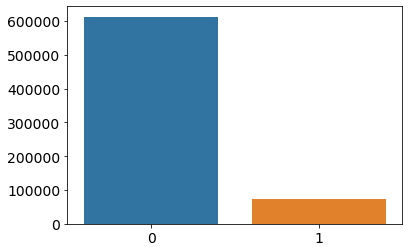

In [12]:
sns.barplot(target.value_counts().index, target.value_counts().values);

Количество людей, не совершивших покупки, существенно превышает тех, кто их совершил.

### Признак коммуникации

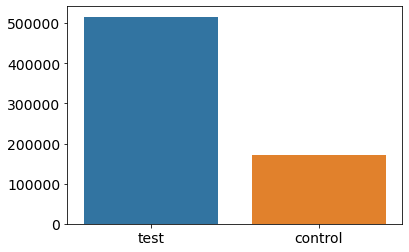

In [13]:
sns.barplot(treatment.value_counts().index, treatment.value_counts().values);

Выборка является несбалансированной, поскольку количество людей в тестовой группе (люди, с которыми проводилась коммуникация) существенно превышает количество людей, находящхся в контрольной группе (люди, с которыми коммуникации не было). 

# Вещественные признаки

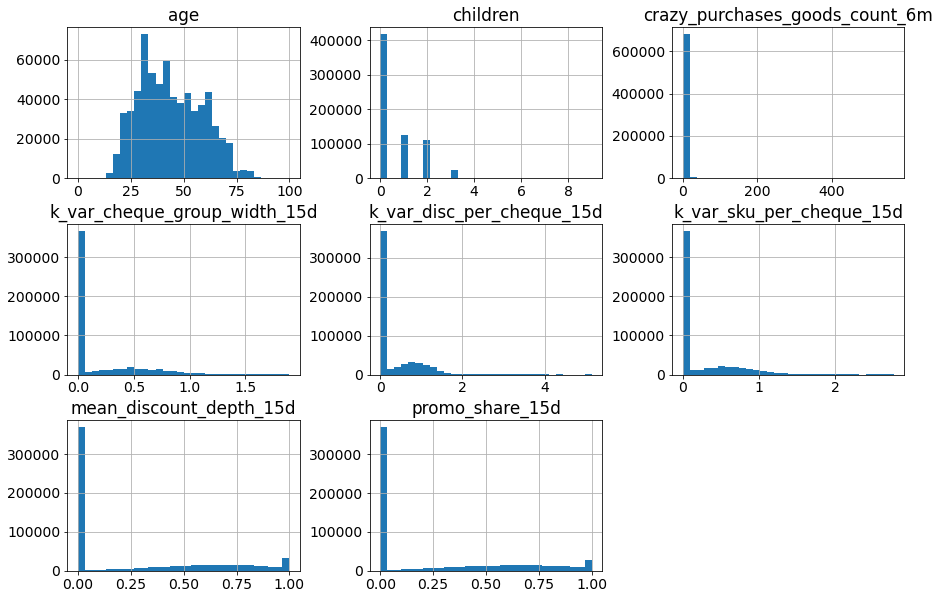

In [14]:
numerical_features = ['age',
        'children', 
        'crazy_purchases_goods_count_6m',
        'k_var_cheque_group_width_15d',
        'k_var_disc_per_cheque_15d',
        'k_var_sku_per_cheque_15d',
        'mean_discount_depth_15d',
        'promo_share_15d']
df[numerical_features].hist(figsize=(15,10), bins=30);

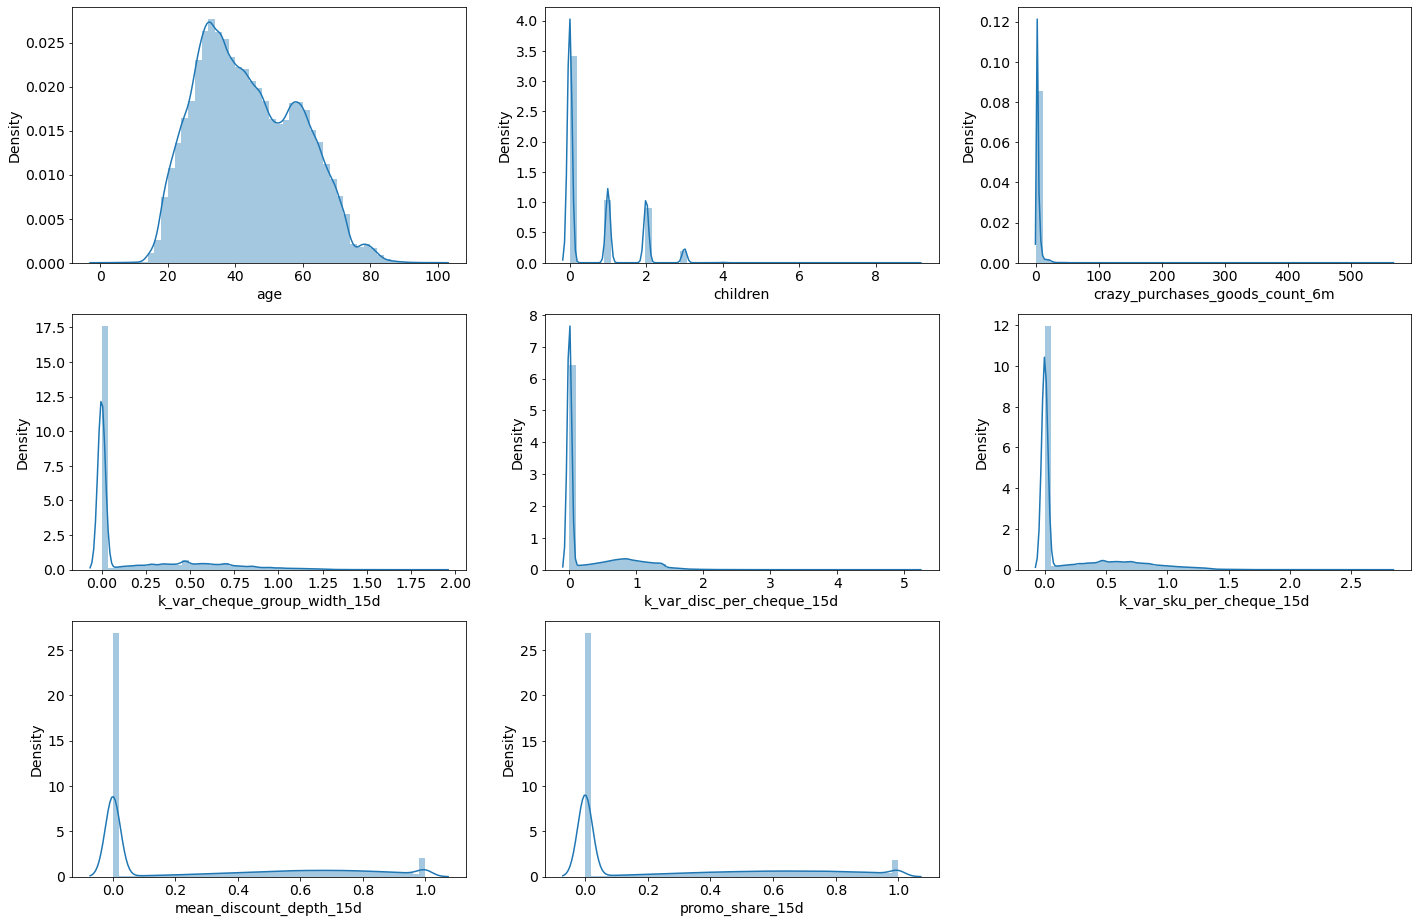

In [15]:
plt.figure(figsize=(24, 16))

plt.subplot(3, 3, 1)
sns.distplot(df['age'])

plt.subplot(3, 3, 2)
sns.distplot(df['children'])

plt.subplot(3, 3, 3)
sns.distplot(df['crazy_purchases_goods_count_6m'])

plt.subplot(3, 3, 4)
sns.distplot(df['k_var_cheque_group_width_15d'])

plt.subplot(3, 3, 5)
sns.distplot(df['k_var_disc_per_cheque_15d'])

plt.subplot(3, 3, 6)
sns.distplot(df['k_var_sku_per_cheque_15d'])

plt.subplot(3, 3, 7)
sns.distplot(df['mean_discount_depth_15d'])

plt.subplot(3, 3, 8)
sns.distplot(df['promo_share_15d'])

plt.show()

Из графиков можно сделать следующие выводы:

1) Распределение признака age имеет три максимума и содержит выбросы. 

2) Признак children распределен дискретно и содержит выбросы.

3) Признаки crazy_purchases_goods_count_6m, k_var_cheque_group_width_15d, k_var_disc_per_cheque_15d,
k_var_sku_per_cheque_15d, mean_discount_depth_15d, promo_share_15d скошены в левую сторону.

4) Признаки  k_var_cheque_group_width_15d, k_var_disc_per_cheque_15d, k_var_sku_per_cheque_15d имеют схожие распределения

5) Признаки 'mean_discount_depth_15d', 'promo_share_15d' также имеют схожие распределения

Визуализируем выбросы в вещественных признаках при помощи диаграммы "ящик с усами".

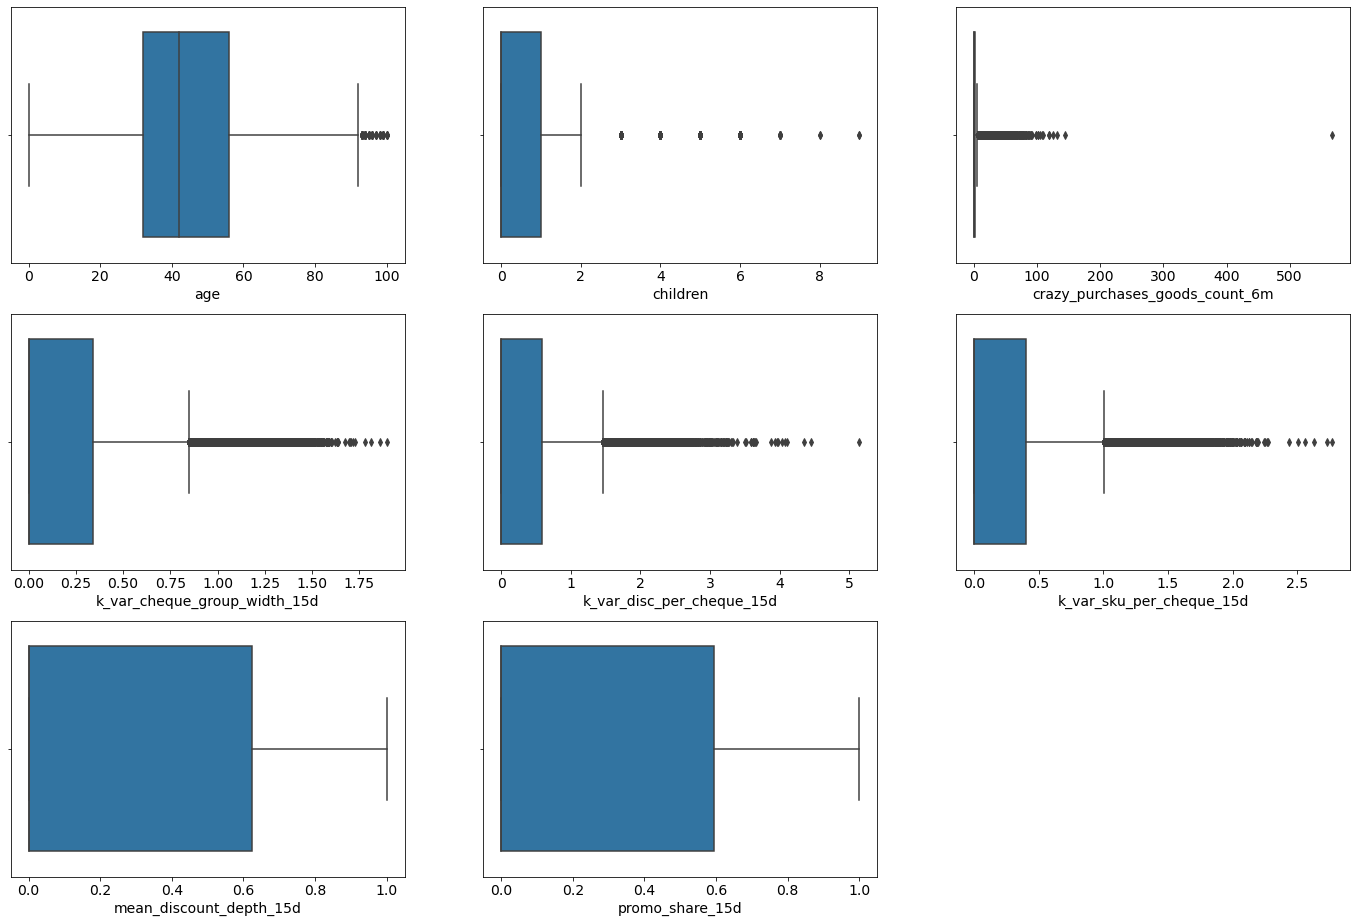

In [16]:
plt.figure(figsize=(24, 16))

plt.subplot(3, 3, 1)
sns.boxplot(df['age'])

plt.subplot(3, 3, 2)
sns.boxplot(df['children'])

plt.subplot(3, 3, 3)
sns.boxplot(df['crazy_purchases_goods_count_6m'])

plt.subplot(3, 3, 4)
sns.boxplot(df['k_var_cheque_group_width_15d'])

plt.subplot(3, 3, 5)
sns.boxplot(df['k_var_disc_per_cheque_15d'])

plt.subplot(3, 3, 6)
sns.boxplot(df['k_var_sku_per_cheque_15d'])

plt.subplot(3, 3, 7)
sns.boxplot(df['mean_discount_depth_15d'])

plt.subplot(3, 3, 8)
sns.boxplot(df['promo_share_15d'])

plt.show()

### Бинарные признаки

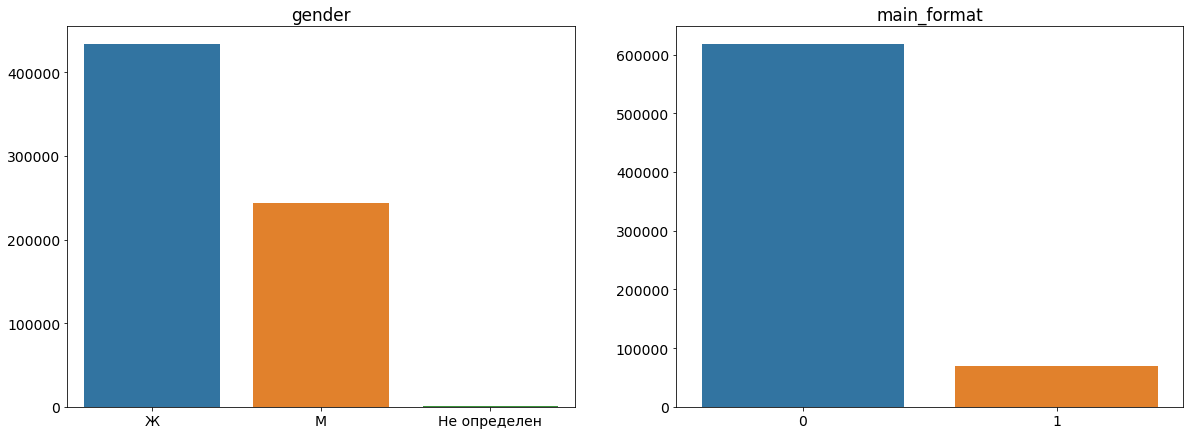

In [17]:
plt.figure(figsize=(20,7)) 
plt.subplot(1, 2, 1)   
plt.title('gender')
sns.barplot(df['gender'].value_counts().index, df['gender'].value_counts().values)

plt.subplot(1, 2, 2)   
plt.title('main_format')
sns.barplot(df['main_format'].value_counts().index, df['main_format'].value_counts().values)
    
plt.show()

1) В признаке gender есть поле со значением "Не определен", которое необходимо обработать. 

2) Женщины своершают покупки чаще мужчин

3) Большинство покупок было совершено в супермаркете.

### 2.2 Матрица корреляций

Строим матрицу корреляций для вещественных признаков.

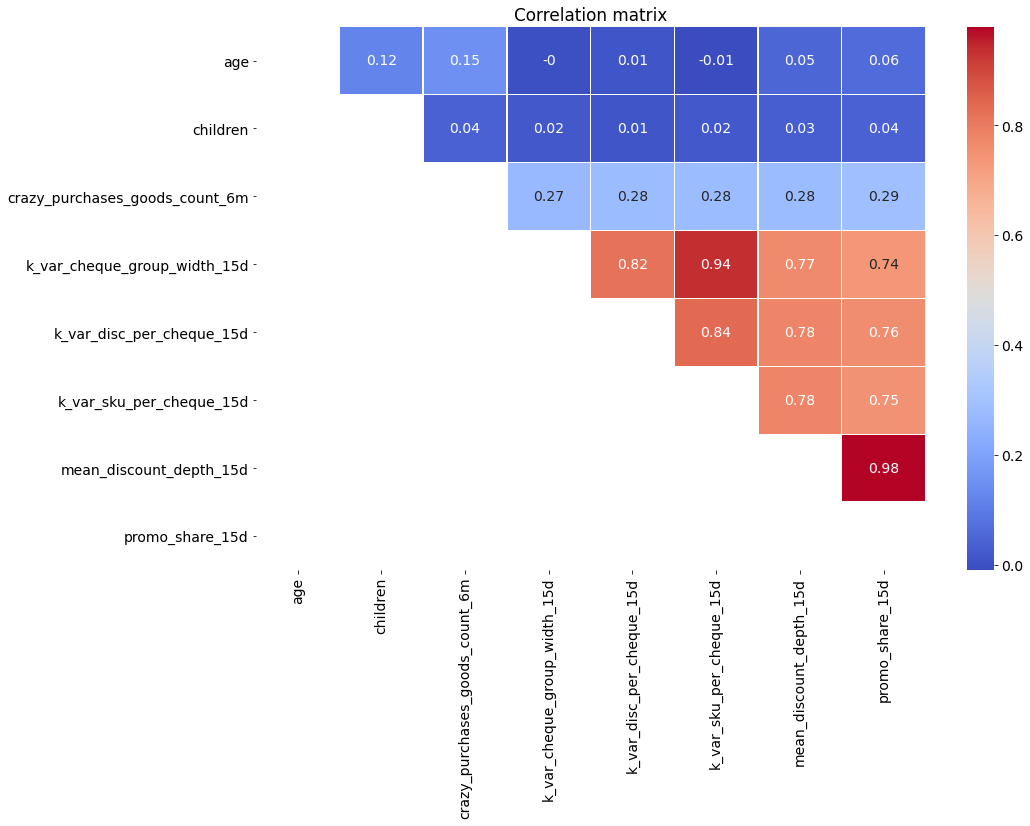

In [18]:
df_num_features = df[['age',
        'children', 
        'crazy_purchases_goods_count_6m',
        'k_var_cheque_group_width_15d',
        'k_var_disc_per_cheque_15d',
        'k_var_sku_per_cheque_15d',
        'mean_discount_depth_15d',
        'promo_share_15d']]

plt.rcParams['figure.figsize'] = (15.0, 10.0)

#sns.set(font_scale=1.4)


corr_matrix = df_num_features.corr()
corr_matrix = np.round(corr_matrix, 2)
mask = np.tril(df_num_features.corr())
#corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm', mask=mask)

plt.title('Correlation matrix')
plt.show()

Следующие признаки  имеют выокую степень линейной корреляции между собой, а потому один из них может быть исключен из рассмотрения:

1) k_var_cheque_group_width_15d и k_var_sku_per_cheque_15d

2) mean_discount_depth_15d и promo_share_15d

3) k_var_disc_per_cheque_15d и k_var_sku_per_cheque_15d

4) k_var_disc_per_cheque_15d и k_var_cheque_group_width_15d

### 2.3 Анализ влияния признака коммуникации на некоторые фичи

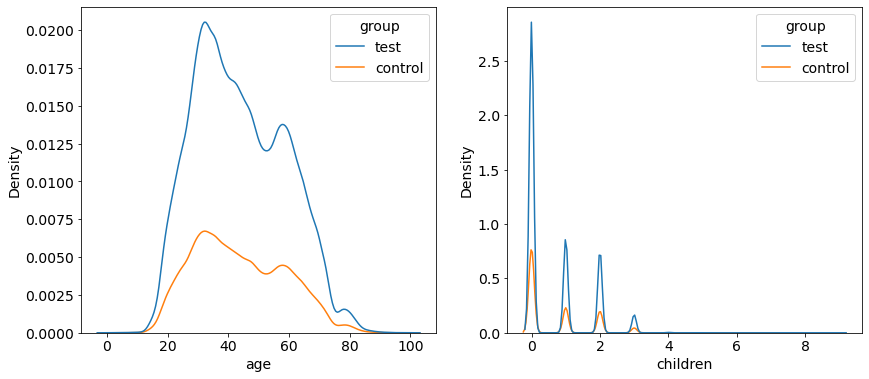

In [19]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  
sns.kdeplot(x='age', data=df, hue=treatment)

plt.subplot(1, 2, 2) 
sns.kdeplot(x='children', data=df, hue=treatment)
    
plt.show();

В целом, поведение клиентов в тестовой и контрольной группах подобно.

## 3. Разбиение на train и test

Приведем признак коммуникации к бинарному виду

In [76]:
treatment = pd.Series(np.where(treatment=='control', 0, 1))

Исключим признаки k_var_disc_per_cheque_15d, k_var_sku_per_cheque_15d, mean_discount_depth_15d,
promo_share_15d так как они обладают линейной зависимостью 

In [77]:
df_final = df[['gender','age','main_format','children', 
              'crazy_purchases_goods_count_6m',
              'k_var_cheque_group_width_15d',
              'promo_share_15d']]

In [78]:
df_final.head()

,gender,age,main_format,children,crazy_purchases_goods_count_6m,k_var_cheque_group_width_15d,promo_share_15d
0,Ж,47.0,0,0.0,11.0,0.7692,0.5821
1,Ж,57.0,1,0.0,0.0,0.0000,0.0000
2,М,38.0,0,3.0,0.0,NaN,0.7256
3,Ж,65.0,1,0.0,0.0,0.0000,0.0000
4,Ж,61.0,0,2.0,2.0,0.7542,0.7865


In [80]:
X_train, X_test, treat_train, treat_test, y_train, y_test = train_test_split(df_final, 
                                                    treatment, target, test_size=0.33, random_state=42)
#save test
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)
treat_test.to_csv('treat_test.csv', index=None)
#save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)
treat_train.to_csv('treat_train.csv', index=None)

## 4. Очистка данных и Feature Engineering

Для заполнения пропущенных данных и обработки выбросов создадим класс DataPipeline.

In [82]:
class DataPipeline(BaseEstimator, TransformerMixin):
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.mode_gen = None
        self.mean_kvar = None
        self.kvar_max_value = None
        self.kvar_min_value = None
        
        
        
    def fit(self, X, y=None, z=None):
        """Сохранение статистик"""

        X = X.copy()
        df = X.copy()
        
        self.medians = X.median() # medians
        self.mode_gen = X['gender'].mode()[0] # mode
        self.mean_kvar = X['k_var_cheque_group_width_15d'].mean() # mean
        
        self.iqr = np.quantile(X['k_var_cheque_group_width_15d'], q=0.75) - np.quantile(X['k_var_cheque_group_width_15d'], q=0.25)
        self.kvar_max_value=np.quantile(X['k_var_cheque_group_width_15d'], q=0.75) + 1.5*self.iqr 
        self.kvar_min_value=np.quantile(X['k_var_cheque_group_width_15d'], q=0.25) - 1.5*self.iqr           

        
        return self
        
       
        
    def transform(self, X, y=None, z=None):
        """Трансформация данных"""
        
        # 1. Обработка пропусков
        #1.1 gender
        # Заменним пропуски на моду
        X.loc[X['gender']=='Не определен', 'gender'] = self.mode_gen
        X['gender'].fillna(self.mode_gen, inplace=True)

        #1.2 children, age, crazy_purchases_goods_count_6m
        # Пропуски заполним медианами
        X['children'].fillna(self.medians['children'], inplace=True)
        X['age'].fillna(self.medians['age'], inplace=True)
        X[['crazy_purchases_goods_count_6m']] = X[['crazy_purchases_goods_count_6m']].fillna(self.medians['crazy_purchases_goods_count_6m'])

        
        #1.3 k_var_cheque_group_width_15d
        # Пропуски заменим средним
        X[['k_var_cheque_group_width_15d']] = X[['k_var_cheque_group_width_15d']].fillna(self.mean_kvar)

        
        # 2. Обработка выбросов (outliers)  
        
        # 2.1 children, age, crazy_purchases_goods_count_6m        
        # Т.к. признаки - целочисленные, то заполним выбросы медианами.
        X.loc[(X['children']) > 5, 'children'] = self.medians['children']
        X.loc[((X['age'] < 15) | (X['age'] > 85)), 'age'] = self.medians['age']
        X.loc[(X['crazy_purchases_goods_count_6m']) > 200, 'crazy_purchases_goods_count_6m'] = self.medians['crazy_purchases_goods_count_6m']

        #2.2 k_var_cheque_group_width_15d        
       
        # Определим выбросы в k_var_cheque_group_width_15d с помощью квантилей.
        #Наблюдения, значения которых больше 97,5% квантиля и которые меньше 2,5% квантиля 
        #будем считать выбросами и заменять на медиану.     
        X.loc[X['k_var_cheque_group_width_15d'] > self.kvar_max_value, 'k_var_cheque_group_width_15d'] = self.kvar_max_value
        X.loc[X['k_var_cheque_group_width_15d'] < self.kvar_min_value, 'k_var_cheque_group_width_15d'] = self.kvar_min_value
                                    

        # 3. Генерация признаков
        
        # Бинарное кодирование признака gender
        X['gender'] = np.where(X['gender']=='Ж', 0, 1)
        
        # Категории признака возраста 
        X = self.age_cat(X)
                
        #Логарифмическое преобразование признаков crazy_purchases_goods_count_6m, k_var_cheque_group_width_15d, promo_share_15d        
        X['Log_crazy'] = (X['crazy_purchases_goods_count_6m']-X['crazy_purchases_goods_count_6m'].min()+1).transform(np.log)
        X['Log_kvar'] = (X['k_var_cheque_group_width_15d']-X['k_var_cheque_group_width_15d'].min()+1).transform(np.log)
        X['Log_promo'] = (X['promo_share_15d']-X['promo_share_15d'].min()+1).transform(np.log)

        
        # Удаляем признаки crazy_purchases_goods_count_6m, k_var_cheque_group_width_15d, promo_share_15d
        X=X[['gender',
             'age',
             'main_format',
             'children', 
             'age_cat',
             'Log_crazy',
             'Log_kvar',
             'Log_promo']]            
            
        return X
    
    def age_cat(self, X):
        
        # Разбиение возраста по категориям        
        X['age_cat'] = 0
        X.loc[X['age'] <= 50, 'age_cat'] = 1
        X.loc[(X['age'] > 50) & (X['age'] <= 75), 'age_cat'] = 2
        X.loc[X['age'] > 75, 'age_cat'] = 3

        return X      

## 5. Обучение модели

In [83]:
estimator = GradientBoostingClassifier(max_features='log2',
                                random_state=42,
                                warm_start=True,
                                max_depth = 3,
                                n_estimators = 200,
                                min_samples_leaf = 100)
sm = SoloModel(estimator=estimator)

In [84]:
pipe = Pipeline(steps=[('my_pipe', DataPipeline()), ('sm', sm)])

In [85]:
pipe = pipe.fit(
    X=X_train,
    y=y_train,
    sm__treatment=treat_train
)

In [86]:
sm_predictions = pipe.predict(X_test)

In [87]:
sm_30 = uplift_at_k(y_test, sm_predictions, treat_test, strategy='by_group')
print(f'uplift@30%: {sm_30:.4f}')

uplift@30%: 0.0063


In [88]:
with open("solomodel_pipeline.dill", "wb") as f:
    dill.dump(pipe, f)